# CCM Final Project
#### Baysian Modeling of Orientation WM prior

### Content
1. Load and Sort data
2. Prior Model Simulate
3. Fit Prior Model
4. Validation of Prior Model (Recover the params from the simulated data)

### 1. Load and Sort Data

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import logsumexp

In [3]:
curr_dif = os.getcwd()
data_dir = os.path.abspath(os.path.join(curr_dif, '..\\..\\'))
os.listdir(data_dir)

['.Rhistory',
 '.Rproj.user',
 'CCM_finalProject',
 'CCM_Final_23Spring.Rproj',
 'data',
 'data_beh.csv',
 'figures',
 'scripts']

In [4]:
data_path = os.path.join(data_dir,'data_beh.csv')
data = pd.read_csv(data_path,sep=',')

print(data.head())

   subjID  run  trial  phase  oriRef  oriJitt  oriFinal  oriRespInit  \
0       1    1      1      9       2       -9        36           63   
1       1    1      2      3       1       -9       171           85   
2       1    1      3      4       2       -1        44           58   
3       1    1      4      1       3        6        96           12   
4       1    1      5      3       4        3       138           43   

   oriRespFinal  error  points        rt  outoftime  iti  
0            62    -26      48  2.609021        NaN  0.2  
1           165      6      88  3.047162        NaN  0.2  
2            53     -9      82  2.500657        NaN  0.2  
3            99     -3      94  3.697208        NaN  0.2  
4           143     -5      90  3.665645        NaN  0.2  


In [49]:
data_df = pd.DataFrame(data)
flag = data_df['outoftime']!=1
print(sum(flag))
data_clean = data_df[flag]
# Kay: some additional cleaning and recoding
data_clean['oriRef2'] = (data_clean['oriRef']-1) * 45
data_clean['oriFinal2'] = data_clean['oriRef2'] + data_clean['oriJitt']
data_clean['oriRespFinal2'] = data_clean['oriFinal2'] - data_clean['error']
data_clean['oriFinal3'] = data_clean['oriJitt']
data_clean['oriRespFinal3'] = data_clean['oriRespFinal2'] - data_clean['oriRef2']
data_clean = data_clean[data_clean['error'].abs() < 22.55]
data_clean

2319


C:\Users\kay\AppData\Local\Temp\ipykernel_28756\447142464.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['oriRef2'] = (data_clean['oriRef']-1) * 45
C:\Users\kay\AppData\Local\Temp\ipykernel_28756\447142464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['oriFinal2'] = data_clean['oriRef2'] + data_clean['oriJitt']
C:\Users\kay\AppData\Local\Temp\ipykernel_28756\447142464.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,subjID,run,trial,phase,oriRef,oriJitt,oriFinal,oriRespInit,oriRespFinal,error,points,rt,outoftime,iti,oriRef2,oriFinal2,oriRespFinal2,oriFinal3,oriRespFinal3
1,1,1,2,3,1,-9,171,85,165,6,88,3.047162,NaN,0.2,0,-9,-15,-9,-15
2,1,1,3,4,2,-1,44,58,53,-9,82,2.500657,NaN,0.2,45,44,53,-1,8
3,1,1,4,1,3,6,96,12,99,-3,94,3.697208,NaN,0.2,90,96,99,6,9
4,1,1,5,3,4,3,138,43,143,-5,90,3.665645,NaN,0.2,135,138,143,3,8
5,1,1,6,7,1,-9,171,152,164,7,86,1.547777,NaN,0.2,0,-9,-16,-9,-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,15,1,155,7,3,-1,89,93,88,1,98,2.375790,NaN,0.2,90,89,88,-1,-2
2395,15,1,156,1,3,0,90,18,91,-1,98,2.757365,NaN,0.2,90,90,91,0,1
2397,15,1,158,5,4,1,136,149,127,9,82,2.387765,NaN,0.2,135,136,127,1,-8
2398,15,1,159,2,2,-6,39,20,46,-7,86,1.181797,NaN,0.2,45,39,46,-6,1


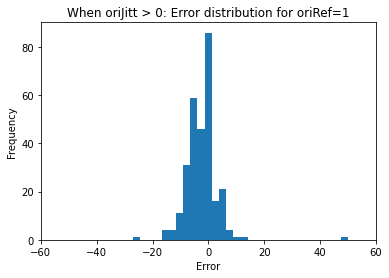

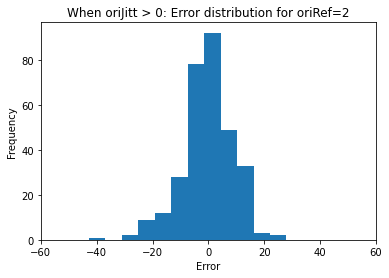

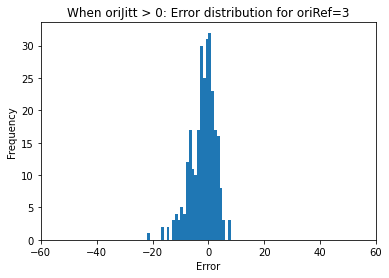

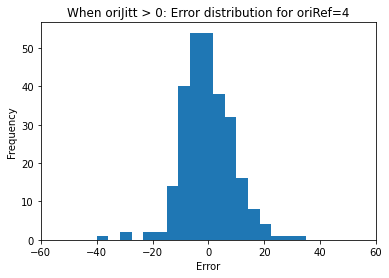

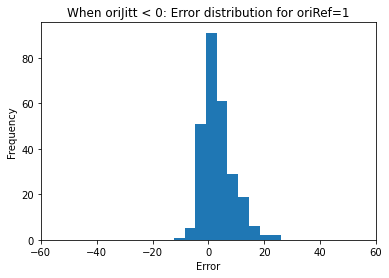

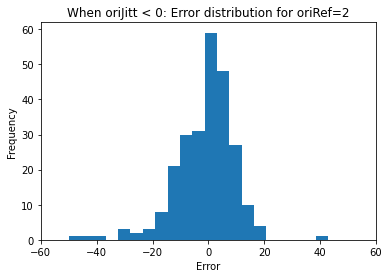

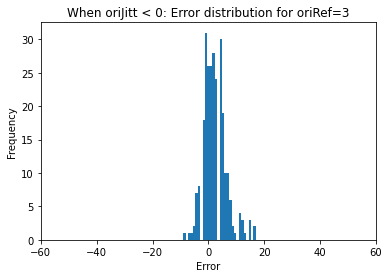

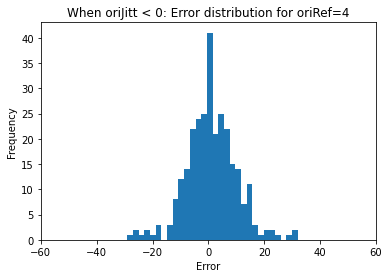

In [48]:
oriRefs = np.unique(data_clean['oriRef'])
data_clean_pos = data_clean[data_clean['oriJitt'] > 0]


for oriRef in oriRefs:
    data_oriRef = data_clean_pos[data_clean_pos['oriRef'] == oriRef]
    plt.hist(data_oriRef['error'], bins=30)
    plt.xlim(-60, 60)
    plt.title(f'When oriJitt > 0: Error distribution for oriRef={oriRef}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()
    
# Kay: an visualization
oriRefs = np.unique(data_clean['oriRef'])
data_clean_neg = data_clean[data_clean['oriJitt'] < 0]


for oriRef in oriRefs:
    data_oriRef = data_clean_neg[data_clean_neg['oriRef'] == oriRef]
    plt.hist(data_oriRef['error'], bins=30)
    plt.xlim(-60, 60)
    plt.title(f'When oriJitt < 0: Error distribution for oriRef={oriRef}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

### 2. Modelling

In [33]:
data_ref2 = data_clean[data_clean['oriRef2'] == 45]
subject1_ref2 = data_ref2[data_ref2['subjID']== 1]
targ_loc_s1r2 = np.array(subject1_ref2['oriFinal3'])
real_response_s1r2 = np.array(subject1_ref2['oriRespFinal3'])

In [34]:
def prior_nll(targ_loc,true_answer, prior_std, likelihood_std):
    ntrials = targ_loc.shape[0]
    xs = np.linspace(-90, 90, 181)
    prior_mu = 0
    log_prior = norm.logpdf(xs, loc=prior_mu, scale=prior_std)
    log_prior = np.tile(log_prior, (ntrials, 1))
    log_likelihood = norm.logpdf(xs.reshape(1, -1), loc=targ_loc[:, np.newaxis], scale=likelihood_std)
    log_post_unnormalized = log_likelihood + log_prior
    normalizing_factor = np.tile(logsumexp(log_post_unnormalized, axis =1), (len(xs), 1)).T
    log_post = log_post_unnormalized - normalizing_factor
    nll = -log_post
    nLL = []
    for i in range(0,len(true_answer)):
        trial_true = (true_answer[i] + 90).astype(int)
        trail_nll = nll[i, :]
        trail_nLL = trail_nll[trial_true]
        nLL.append(trail_nLL)
    return np.sum(np.array(nLL))

In [35]:
prior_nll(targ_loc_s1r2,real_response_s1r2, 10, 10)

166.19800143674985

In [36]:
def non_prior_nll(targ_loc,true_answer, likelihood_std):
    ntrials = targ_loc.shape[0]
    xs = np.linspace(-90, 90, 181)
    log_likelihood = norm.logpdf(xs.reshape(1, -1), loc=targ_loc[:, np.newaxis], scale=likelihood_std)
    log_post_unnormalized = log_likelihood
    normalizing_factor = np.tile(logsumexp(log_post_unnormalized, axis =1), (len(xs), 1)).T
    log_post = log_post_unnormalized - normalizing_factor
    nll = -log_post
    nLL = []
    for i in range(0,len(true_answer)):
        trial_true = (true_answer[i] + 90).astype(int)
        trail_nll = nll[i, :]
        trail_nLL = trail_nll[trial_true]
        nLL.append(trail_nLL)
    return np.sum(np.array(nLL))

In [37]:
non_prior_nll(targ_loc_s1r2,real_response_s1r2, 10)

149.74094504794874

In [38]:
def wrapped_prior_nll(params, targ_loc, true_answer):
    prior_std, likelihood_std = params
    return prior_nll(targ_loc,true_answer, prior_std, likelihood_std)

init_guess_prior = [10, 10]  # [prior_std_guess, likelihood_std_guess]

In [39]:
result_prior_s1r2 = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(targ_loc_s1r2, real_response_s1r2), bounds=((1e-5, 500), (1e-5, 100)))
op_prior_std_s1r2, op_prior_likelihood_std_s1r2 = result_prior_s1r2.x

print("Optimized nll (with prior):", prior_nll(targ_loc_s1r2,real_response_s1r2, op_prior_std_s1r2, op_prior_likelihood_std_s1r2))
print("Optimized prior_std:", op_prior_std_s1r2)
print("Optimized likelihood_std (with prior):", op_prior_likelihood_std_s1r2)

Optimized nll (with prior): 149.72443607241541
Optimized prior_std: 500.0
Optimized likelihood_std (with prior): 10.21968474492329


In [40]:
def wrapped_non_prior_nll(params, targ_loc, true_answer):
    likelihood_std = params
    return non_prior_nll(targ_loc,true_answer, likelihood_std)

init_guess_non_prior = [10]  # [likelihood_std_guess]

In [41]:
result_no_prior_s1r2 = minimize(wrapped_non_prior_nll, init_guess_non_prior, 
                                   args=(targ_loc_s1r2, real_response_s1r2), bounds=((1e-5, 500),))
op_nonprior_likelihood_std_s1r2 = result_no_prior_s1r2.x[0]

print("Optimized nll(without prior):", non_prior_nll(targ_loc_s1r2,real_response_s1r2, op_nonprior_likelihood_std_s1r2))
print("Optimized likelihood_std (without prior):", op_nonprior_likelihood_std_s1r2)

Optimized nll(without prior): 149.72213483715782
Optimized likelihood_std (without prior): 10.217632469429512


### 3. Validation of Model (Recover the params from the simulated data)

In [15]:
def generate_synthetic_data_prior(n_samples, prior_mu, prior_std, likelihood_std):
    xs = np.linspace(-90, 90, 181)
    targ_loc = []
    real_response = []
    prior = norm.pdf(xs, loc= prior_mu, scale = prior_std)
    for i in range(0, n_samples):
        targ_loc_i = np.round(np.random.normal(loc=prior_mu, scale = prior_std, size = 1))
        likelihood_i = norm.pdf(xs, loc= targ_loc_i, scale = likelihood_std)
        post_i = prior * likelihood_i
        post_i = post_i/np.sum(post_i)
        real_response_i = np.random.choice(xs, p =post_i)
        targ_loc.append(targ_loc_i)
        real_response.append(real_response_i)
    return np.array(targ_loc).flatten(), np.array(real_response)

n_samples = 1000
prior_mu = 0
prior_std_sim = 5
likelihood_std_sim = 30

targ_loc_sim, true_answer_sim = generate_synthetic_data_prior(n_samples, prior_mu, prior_std_sim, likelihood_std_sim)

In [16]:
result_prior_synthetic = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(targ_loc_sim, true_answer_sim), bounds=((1e-5, 500), (1e-5, 500)))
recovered_prior_std, recovered_prior_likelihood_std = result_prior_synthetic.x

print("Original nll (with prior):", prior_nll(targ_loc_sim, true_answer_sim, prior_std_sim, likelihood_std_sim))
print("Optimized nll (with prior):", prior_nll(targ_loc_sim, true_answer_sim, recovered_prior_std, recovered_prior_likelihood_std))
print("True prior_std:", prior_std_sim)
print("Recovered prior_std (with prior):", recovered_prior_std)
print("True likelihood_std (with prior):", likelihood_std_sim)
print("Recovered likelihood_std (with prior):", recovered_prior_likelihood_std)

Original nll (with prior): 3043.9083849711424
Optimized nll (with prior): 3041.8953614849515
True prior_std: 5
Recovered prior_std (with prior): 5.0683018829618876
True likelihood_std (with prior): 30
Recovered likelihood_std (with prior): 494.6581244882343


In [17]:
result_no_prior_synthetic = minimize(wrapped_non_prior_nll, init_guess_non_prior, 
                                   args=(targ_loc_sim, true_answer_sim), bounds=((1e-5, 500),))
recovered_no_prior_likelihood_std = result_no_prior_synthetic.x[0]

print("Original nll (with prior):", prior_nll(targ_loc_sim, true_answer_sim, prior_std_sim, likelihood_std_sim))
print("Optimized nll (without prior):", non_prior_nll(targ_loc_sim, true_answer_sim, recovered_no_prior_likelihood_std))
print("True prior_std:", prior_std_sim)
print("Recovered prior_std (with prior):", "no prior proposed")
print("True likelihood_std (with prior):", likelihood_std_sim)
print("Recovered likelihood_std (without prior):", recovered_no_prior_likelihood_std)

Original nll (with prior): 3043.9083849711424
Optimized nll (without prior): 3400.6481804604923
True prior_std: 5
Recovered prior_std (with prior): no prior proposed
True likelihood_std (with prior): 30
Recovered likelihood_std (without prior): 7.255134671434752


In [18]:
# Calculate NLL for both models using optimal parameters
nll_prior = prior_nll(targ_loc_sim, true_answer_sim, recovered_prior_std, recovered_prior_likelihood_std)
nll_non_prior = non_prior_nll(targ_loc_sim, true_answer_sim, recovered_no_prior_likelihood_std)

# Calculate the number of parameters (k) for each model
k_prior = 2  # prior_std and likelihood_std
k_non_prior = 1  # likelihood_std

# Calculate AIC for each model
aic_prior = 2 * 2 + 2 * nll_prior
aic_non_prior = 2 * 1 + 2 * nll_non_prior

# Calculate BIC for each model
# Calculate the number of samples (n)
n_samples = targ_loc_sim.shape[0]
bic_prior = 2 * np.log(n_samples) + 2 * nll_prior
bic_non_prior = 1 * np.log(n_samples) + 2 * nll_non_prior

print("AIC (prior model):", aic_prior)
print("AIC (non-prior model):", aic_non_prior)
print("BIC (prior model):", bic_prior)
print("BIC (non-prior model):", bic_non_prior)

AIC (prior model): 6087.790722969903
AIC (non-prior model): 6803.296360920985
BIC (prior model): 6097.6062335278675
BIC (non-prior model): 6808.204116199967


In [24]:
n_sims = 1000
n_samples = 1000
prior_mu = 0

sim_prior_std = []
sim_prior_likelihood_std = []
sim_initial_prior_nll = []

sim_recovered_prior_std = []
sim_recovered_prior_likelihood_std = []
sim_recovered_prior_nll = []
sim_prior_AIC = []
sim_prior_BIC = []

sim_recovered_no_prior_likelihood_std = []
sim_recovered_no_prior_nll = []
sim_no_prior_AIC = []
sim_no_prior_BIC = []

for i in range(0, n_sims):
    
    # Initialize parameters
    i_prior_std = np.random.randint(1, 20, )
    sim_prior_std.append(i_prior_std)
    i_likelihood_std = np.random.randint(1, 20, )
    sim_prior_likelihood_std.append(i_likelihood_std)
    
    # Generate data
    sim_targ_loc, sim_true_answer = generate_synthetic_data_prior(n_samples, prior_mu, i_prior_std, i_likelihood_std)
    sim_initial_prior_nll.append(prior_nll(sim_targ_loc,sim_true_answer, i_prior_std, i_likelihood_std))
    
    # Fit prior model
    init_guess_prior = [np.random.normal(20, 15), np.random.normal(20, 15)]
    sim_result_prior_synthetic = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(sim_targ_loc, sim_true_answer), bounds=((1e-5, 500), (1e-5, 500)))
    i_recovered_prior_std, i_recovered_prior_likelihood_std = sim_result_prior_synthetic.x
    sim_recovered_prior_std.append(i_recovered_prior_std)
    sim_recovered_prior_likelihood_std.append(i_recovered_prior_likelihood_std)
    i_nll_prior = prior_nll(sim_targ_loc,sim_true_answer, i_recovered_prior_std, i_recovered_prior_likelihood_std)
    sim_recovered_prior_nll.append(i_nll_prior)
    i_aic_prior = 2 * 2 + 2 * i_nll_prior
    sim_prior_AIC.append(i_aic_prior)
    i_bic_prior = 2 * np.log(n_samples) + 2 * i_nll_prior
    sim_prior_BIC.append(i_bic_prior)
    
    # Fit non-prior model
    init_guess_no_prior = [np.random.normal(20, 15)]
    sim_result_no_prior_synthetic = minimize(wrapped_non_prior_nll, init_guess_no_prior, 
                                   args=(sim_targ_loc, sim_true_answer), bounds=((1e-5, 500),))
    i_recovered_no_prior_likelihood_std = sim_result_no_prior_synthetic.x[0]
    sim_recovered_no_prior_likelihood_std.append(i_recovered_no_prior_likelihood_std)
    i_nll_no_prior = non_prior_nll(sim_targ_loc,sim_true_answer, i_recovered_no_prior_likelihood_std)
    sim_recovered_no_prior_nll.append(i_nll_no_prior)
    i_aic_no_prior = 2 * 1 + 2 * i_nll_no_prior
    sim_no_prior_AIC.append(i_aic_no_prior)
    i_bic_no_prior = 1 * np.log(n_samples) + 2 * i_nll_no_prior
    sim_no_prior_BIC.append(i_bic_no_prior)

In [25]:
output_dict = {
    'prior_std':sim_prior_std,
    'recovered_prior_std': sim_recovered_prior_std,
    'likelihood_std':sim_prior_likelihood_std,
    'recovered_likelihood_std (with prior)': sim_recovered_prior_likelihood_std,
    'recovered_likelihood_std (without prior)': sim_recovered_no_prior_likelihood_std,
    'initial_nll (with prior)': sim_initial_prior_nll,
    'recovered_nll (with prior)': sim_recovered_prior_nll,
    'recovered_nll (without prior)': sim_recovered_no_prior_nll,
    'AIC (with prior)': sim_prior_AIC,
    'AIC (without prior)': sim_no_prior_AIC,
    'BIC (with prior)': sim_prior_BIC,
    'BIC (without prior)': sim_no_prior_BIC
}

simulation_df = pd.DataFrame(output_dict)
pd.set_option('display.max_rows', None)
simulation_df

,prior_std,recovered_prior_std,likelihood_std,recovered_likelihood_std (with prior),recovered_likelihood_std (without prior),initial_nll (with prior),recovered_nll (with prior),recovered_nll (without prior),AIC (with prior),AIC (without prior),BIC (with prior),BIC (without prior)
0,13,11.266206,1,0.978165,0.979286,1393.837111,1393.106437,1398.006443,2790.212873,2798.012886,2800.028384,2802.920642
1,8,8.044955,6,5.870095,5.519692,2975.754104,2975.379901,3127.260599,5954.759802,6256.521197,5964.575313,6261.428952
2,5,4.584449,4,3.938803,3.648288,2516.798859,2513.399821,2713.196349,5030.799642,5428.392699,5040.615152,5433.300454
3,6,6.105246,7,6.988049,5.696490,2944.653502,2944.494022,3158.788755,5892.988045,6319.577510,5902.803555,6324.485265
4,11,11.167951,19,18.803132,12.665274,3681.050365,3680.910504,3957.801903,7365.821008,7917.603806,7375.636519,7922.511561
5,5,4.843213,8,7.919882,5.595266,2838.379448,2837.666616,3140.859391,5679.333231,6283.718781,5689.148742,6288.626536
6,15,499.999566,4,4.007122,4.006994,2770.037635,2806.914389,2806.979839,5617.828778,5615.959678,5627.644288,5620.867433
7,9,9.142325,8,8.014171,7.196045,3215.220182,3215.104181,3392.469488,6434.208361,6786.938976,6444.023872,6791.846732
8,12,12.174467,9,8.482709,7.979154,3361.739899,3359.100938,3495.771721,6722.201875,6993.543441,6732.017386,6998.451197
9,18,17.908789,9,8.752046,8.589136,3481.813557,3481.143203,3569.434731,6966.286406,7140.869463,6976.101917,7145.777218


In [26]:
# simulation_df[simulation_df['BIC (with prior)'] > simulation_df['BIC (without prior)']]

The correlation between prior_std and recovered_prior_std is: 0.986


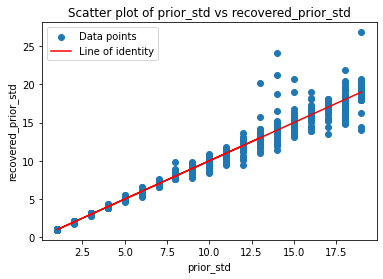

In [27]:
simulation_df1 = simulation_df[simulation_df['recovered_prior_std'] < 30]
corr = simulation_df1['prior_std'].corr(simulation_df1['recovered_prior_std'])
print(f"The correlation between prior_std and recovered_prior_std is: {corr:.3f}")

x = simulation_df1['prior_std']
y = simulation_df1['recovered_prior_std']

plt.scatter(x, y, label='Data points')
plt.plot(x, x, color='r', label='Line of identity')
plt.xlabel('prior_std')
plt.ylabel('recovered_prior_std')
plt.title('Scatter plot of prior_std vs recovered_prior_std')
plt.legend()
plt.show()

The correlation between likelihood_std and recovered_likelihood_std (with prior) is: 0.924


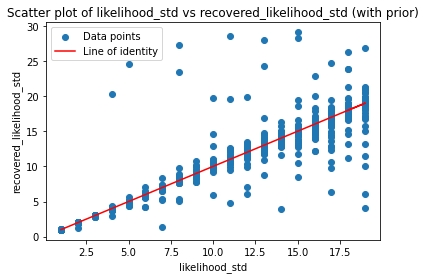

In [28]:
simulation_df2 = simulation_df[simulation_df['recovered_likelihood_std (with prior)'] < 30]
corr2 = simulation_df2['likelihood_std'].corr(simulation_df2['recovered_likelihood_std (with prior)'])
print(f"The correlation between likelihood_std and recovered_likelihood_std (with prior) is: {corr2:.3f}")

x = simulation_df2['likelihood_std']
y = simulation_df2['recovered_likelihood_std (with prior)']

plt.scatter(x, y, label='Data points')
plt.plot(x, x, color='r', label='Line of identity')
plt.xlabel('likelihood_std')
plt.ylabel('recovered_likelihood_std')
plt.title('Scatter plot of likelihood_std vs recovered_likelihood_std (with prior)')
plt.legend()
plt.show()

The correlation between likelihood_std and recovered_likelihood_std (with prior) is: 0.716


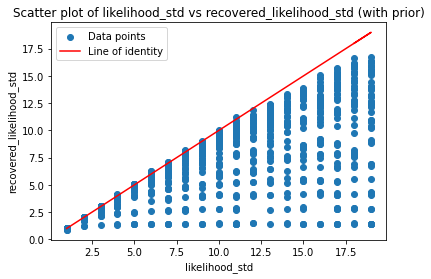

In [29]:
simulation_df3 = simulation_df[simulation_df['recovered_likelihood_std (without prior)'] < 30]
corr3 = simulation_df3['likelihood_std'].corr(simulation_df3['recovered_likelihood_std (without prior)'])
print(f"The correlation between likelihood_std and recovered_likelihood_std (with prior) is: {corr3:.3f}")

x = simulation_df3['likelihood_std']
y = simulation_df3['recovered_likelihood_std (without prior)']

plt.scatter(x, y, label='Data points')
plt.plot(x, x, color='r', label='Line of identity')
plt.xlabel('likelihood_std')
plt.ylabel('recovered_likelihood_std')
plt.title('Scatter plot of likelihood_std vs recovered_likelihood_std (with prior)')
plt.legend()
plt.show()

### 4. Fit Model to Subject Data

In [44]:
unique_oriRef2 = data_clean['oriRef2'].unique()
unique_SubjID = data_clean['subjID'].unique()
init_guess_prior = [20,10]
init_guess_non_prior = [10]

results = []

for i in unique_SubjID:
    for j in unique_oriRef2:
        subset = data_clean[(data_clean['oriRef2'] == j) & (data_clean['subjID'] == i)]
        targ_loc_sub = np.array(subset['oriFinal3'])
        real_response_sub = np.array(subset['oriRespFinal3'])
        n_samples = targ_loc_sub.shape[0]
        
        # Minimize the negative log-likelihood with prior
        result_prior = minimize(wrapped_prior_nll, init_guess_prior, 
                                args=(targ_loc_sub, real_response_sub), bounds=((1e-5, 500), (1e-5, 500)))
        estimated_prior_std, estimated_likelihood_std = result_prior.x
        nll_prior = result_prior.fun
        aic_prior = 2 * 2 + 2 * nll_prior
        bic_prior = 2 * np.log(n_samples) + 2 * nll_prior

        # Minimize the negative log-likelihood without prior
        result_no_prior = minimize(wrapped_non_prior_nll, init_guess_non_prior, 
                                   args=(targ_loc_sub, real_response_sub), bounds=((1e-5, 500),))
        estimated_likelihood_std_no_prior = result_no_prior.x[0]
        nll_no_prior = result_no_prior.fun
        aic_non_prior = 2 * 1 + 2 * nll_no_prior
        bic_non_prior = 1 * np.log(n_samples) + 2 * nll_no_prior
        
        results.append({
            'subjID': i,
            'oriRef2': j,
            'prior_std': estimated_prior_std,
            'likelihood_std': estimated_likelihood_std,
            'likelihood_std_no_prior': estimated_likelihood_std_no_prior,
            'nll_prior': nll_prior,
            'nll_no_prior': nll_no_prior,
            'AIC (with prior)': aic_prior,
            'AIC (without prior)':aic_non_prior,
            'BIC (with prior)':bic_prior,
            'BIC (without prior)':bic_non_prior
        })

results_df = pd.DataFrame(results)
results_df

,subjID,oriRef2,prior_std,likelihood_std,likelihood_std_no_prior,nll_prior,nll_no_prior,AIC (with prior),AIC (without prior),BIC (with prior),BIC (without prior)
0,1,0,500.000000,5.742765,5.742387,126.676260,126.672535,257.352519,255.345071,260.730278,257.033950
1,1,45,500.000000,9.475007,9.473317,143.032494,143.029257,290.064987,288.058513,293.392110,289.722075
2,1,90,500.000000,4.806462,4.806245,119.556834,119.554194,243.113668,241.108387,246.491427,242.797267
3,1,135,500.000000,7.303177,7.302399,136.286431,136.285647,276.572862,274.571293,279.950621,276.260173
4,2,0,500.000000,5.818469,5.818075,127.198730,127.196321,258.397459,256.392643,261.775218,258.081522
5,2,45,17.925921,9.539786,8.528986,138.439263,138.933948,280.878526,279.867896,284.205650,281.531458
6,2,90,500.000000,4.207286,4.207136,114.230586,114.228834,232.461173,230.457668,235.838932,232.146548
7,2,135,30.661752,7.064611,6.888394,133.927163,133.951072,271.854325,269.902144,275.232084,271.591023
8,3,0,500.000000,5.844209,5.843801,127.376681,127.372793,258.753363,256.745586,262.131122,258.434466
9,3,45,500.000000,8.345314,8.344160,141.620524,141.620015,287.241048,285.240031,290.618807,286.928910


In [45]:
results_df[results_df['AIC (with prior)'] < results_df['AIC (without prior)']]

,subjID,oriRef2,prior_std,likelihood_std,likelihood_std_no_prior,nll_prior,nll_no_prior,AIC (with prior),AIC (without prior),BIC (with prior),BIC (without prior)
17,5,45,8.715463,10.092858,7.443806,128.913155,133.626515,261.826310,269.253029,265.153433,270.916591
25,7,45,12.455218,9.826116,7.970534,117.709129,118.819461,239.418258,239.638921,242.470979,241.165282
33,9,45,11.630504,7.382838,6.445377,113.708298,114.880547,231.416596,231.761093,234.527292,233.316441


In [46]:
results_df[results_df['BIC (with prior)'] < results_df['BIC (without prior)']]

,subjID,oriRef2,prior_std,likelihood_std,likelihood_std_no_prior,nll_prior,nll_no_prior,AIC (with prior),AIC (without prior),BIC (with prior),BIC (without prior)
17,5,45,8.715463,10.092858,7.443806,128.913155,133.626515,261.82631,269.253029,265.153433,270.916591
